### SECTION: 1 

**STATEMENT : SENTIMENT ANALYSIS ON IMDB MOVIE REVIEWS**

* Movie reviews help users to decide if the movie is worth their time or not
* A summary of all reviews for a movie can help users make this decision by not wasting their time reading all reviews
* Movie-rating websites are often used by critics to post comments and rate movies which help viewers decide if the movie is worth watching
* Sentiment analysis of a movie review can rate how positive or negative a movie review is and hence the overall rating for a movie
* Therefore, the process of understanding if a review is positive or negative can be automated as the machine learns through training and testing the data.

![alt text](https://static.amazon.jobs/teams/53/images/IMDb_Header_Page.jpg?1501027252)

[ Image Sorce] (https://static.amazon.jobs/teams/53/images/IMDb_Header_Page.jpg?1501027252)

### Libraries

In [297]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding , Flatten, Dense , Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from keras.optimizers import adam_v2
from keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

### SECTION: 2

**THE DATASET IS TAKEN FROM:**(https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews)

## About the data

IMDB dataset having 50K movie reviews for natural language processing or Text analytics.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. They have provided a set of 25,000 highly polar movie reviews for training and 25,000 for testing. So, We have to predict the number of positive and negative reviews using either classification or deep learning algorithms.
For more dataset information, please go through the following link,
(http://ai.stanford.edu/~amaas/data/sentiment/)

In [2]:
Movie_data = pd.read_csv("IMDB_Dataset.csv") ; Movie_data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### SECTION: 3

##### Data Distribution

Positive Rating    25000
Negative Rating    25000
dtype: int64

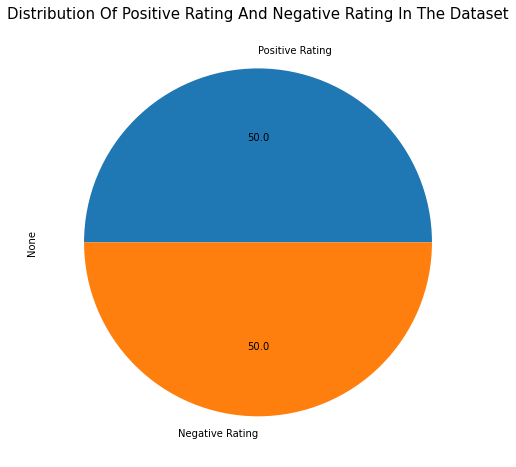

In [342]:
data1 = (pd.DataFrame(Actual_sentiment)).value_counts("positive")
index_ = ["Positive Rating","Negative Rating"]
data1.index = index_
data1.plot.pie(autopct = "%.1f", figsize = (10,8))
plt.title('Distribution Of Positive Rating And Negative Rating In The Dataset', fontsize = 15)
data1

### SECTION: 4

##### Data Preprocessing ( Text preprocessing)

In [4]:
Sentences = Movie_data['review']

In [10]:
Lemmatizer = WordNetLemmatizer()

In [22]:
Corpus = []

for sent in tqdm(list(range(0,len(Sentences)))):
    Review = re.sub('[^a-zA-Z]',' ', Sentences[sent])
    Review = Review.lower()
    words = nltk.word_tokenize(Review)
    lemma = [Lemmatizer.lemmatize(word) for word in words if not word in stopwords.words('english')]
    lemma = ' '.join(lemma)
    Corpus.append(lemma)

100%|████████████████████████████████████████████████████████████████████████████| 50000/50000 [27:20<00:00, 30.48it/s]


* Here we have deleted all special character words present in the reviews
* We have lower case all the words
* We have applied lemmatization to each and every word present in the dataset
* Now we will vectorize the pre-processed corpus 

In [125]:
tokenizer = Tokenizer()

In [126]:
tokenizer.fit_on_texts(Corpus)

In [331]:
word_index = tokenizer.word_index
print("Total number of unique words present in the dataset (except stopwords) : ",len(word_index))
#word_index

Total number of unique words present in the dataset (except stopwords) :  89753


###### 

In [128]:
token_data = tokenizer.texts_to_sequences(Corpus)

In [209]:
max_length = 300

# Post padding of the data
padded_token_data = pad_sequences(token_data,maxlen = max_length,truncating = 'post',padding = "post")

In [210]:
Actual_sentiment = pd.get_dummies(Movie_data['sentiment'])['positive']  ## positive : 1 and Negative : 0

### SECTION: 5

##### Train Test Split

In [211]:
## Train Test Split

X_train, X_test, y_train, y_test = train_test_split(padded_token_data, Actual_sentiment, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(f" Length of train set is :  {len(y_train)}")
print(f" Length of test set is :  {len(y_test)}")
print(f" Length of validation set is :  {len(y_val)}")

 Length of train set is :  32000
 Length of test set is :  10000
 Length of validation set is :  8000


### SECTION: 6

##### Model Building

In [261]:
def Model():
    model=Sequential()

    model.add(Embedding(len(tokenizer.word_index) + 1,10,input_length=max_length))
    model.add(Flatten())
    model.add(Dense(16, activation= 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(64, activation= 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation = "sigmoid"))
    return model

#### Now we have used deep learning optimizer Adam with particular batch size = 256 

Note : 
* To reduce the effect of Overfitting we have introduced an early-stopping criteria based on the validation loss with patience = 15

* we are initially starting the leraning as 0.01 and then changing the learning rate using ReduceLROnPlateau function      which reduce learning rate when a metric has stopped improving.

### Adam optimizer

**Algorithm Adam**

*Input:* global learning rate factor $\alpha$, decay rates $\rho_1$ and $\rho_2$, initial parameters $w \in R^d$.

* Initialize $r \leftarrow 0 \in R^d$
* Initialize timestep $t \leftarrow 0$

* **loop**
  * update timestep $t \leftarrow t + 1$
  * select a minibatch $\mathcal{B}$ of size $B$
  * compute the stochastic gradient $g \leftarrow \frac{1}{B} \sum_{i \in \mathcal{B}} \nabla f_i(w)$
  * accumulate first moment estimate $s_j \leftarrow \rho_1 s_j + (1 - \rho_1) g_j$ for all $j \in \{1, \ldots, d \}$
  * accumulate second moment estimate $r_j \leftarrow \rho_2 r_j + (1 - \rho_2) g_j^2$ for all $j \in \{1, \ldots, d \}$
  * correct first moment bias $\hat s \leftarrow \frac{s}{1 - \rho_1^t}$ 
  * correct second moment bias $\hat r \leftarrow \frac{r}{1 - \rho_2^t}$
  * update model $w_j \rightarrow w_j - \frac{\alpha}{\sqrt{\hat r_j}} \cdot \hat s_j$ for all $j \in \{1, \ldots, d \}$

**Adam** is Modified RMSProp to  use momentum with exponential weighting, and correct for bias to
estimate the first-order and second-order moments of the gradients

In [262]:
model = Model()
optimizer = adam_v2.Adam(learning_rate= 0.01, beta_1=0.9, beta_2=0.999)

model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['binary_accuracy'])

In [263]:
callbacks = [EarlyStopping(monitor='val_loss', patience=15,verbose=1),
             ModelCheckpoint(filepath='best_model_loss.h5', monitor='val_loss', save_best_only=True,verbose=0),
             ReduceLROnPlateau(monitor="val_loss",factor=0.1, patience=10,verbose=1,mode="min",min_lr=0.000000001,cooldown=1)
            ]

In [264]:
epochs = 70
batch_size = 256

model.summary()
history = model.fit(x_train, y_train, epochs=70,validation_data=(x_val, y_val), verbose=1,callbacks=callbacks,
                    batch_size = batch_size,steps_per_epoch=x_train.shape[0] // batch_size)

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_36 (Embedding)    (None, 300, 10)           897540    
                                                                 
 flatten_36 (Flatten)        (None, 3000)              0         
                                                                 
 dense_117 (Dense)           (None, 16)                48016     
                                                                 
 batch_normalization_35 (Bat  (None, 16)               64        
 chNormalization)                                                
                                                                 
 dropout_56 (Dropout)        (None, 16)                0         
                                                                 
 dense_118 (Dense)           (None, 64)                1088      
                                                     

In [344]:
model.load_weights('best_model_loss.h5')

train_accuracy = model.evaluate(x_train,y_train, verbose = 0)
val_accuracy = model.evaluate(x_val,y_val, verbose = 0)
test_accuracy = model.evaluate(X_test,y_test, verbose = 0)

print('\033[1m'+"Train Accuracy : ", train_accuracy[1])
print('\033[1m'+"Validation Accuracy : ", val_accuracy[1])
print('\033[1m'+"Test Accuracy : ", test_accuracy[1])

Train Accuracy :  0.980093777179718
Validation Accuracy :  0.8852499723434448
Test Accuracy :  0.8827999830245972


### SECTION: 7

##### Plots of loss and accuracy

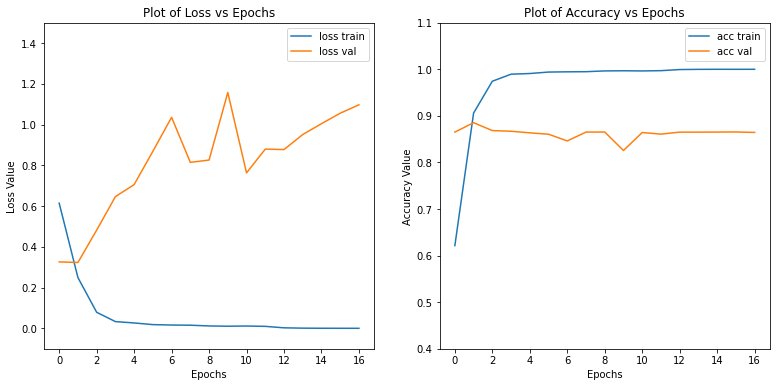

In [280]:
fig = plt.figure(figsize = (13,6))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
    
ax.plot(history.history['loss'], label='loss train')
ax.plot(history.history['val_loss'], label='loss val')
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss Value")
ax.set_ylim(-0.1,1.5)
ax.set_title("Plot of Loss vs Epochs")
ax.legend(loc='best')
    
ax2.plot(history.history['binary_accuracy'], label='acc train')
ax2.plot(history.history['val_binary_accuracy'], label='acc val')
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy Value")
ax2.set_title("Plot of Accuracy vs Epochs")
ax2.set_ylim(0.4,1.1)
ax2.legend(loc = 'best')
plt.show()

### SECTION: 8

##### Visualization of how model predict the data

In [346]:
def decision_boundary(prob):
    if prob >= .5:
        return "Positive"
    else:
        return "Negative"

In [348]:
example = ["The flim is very terrible boring"]

print(" The review is : ", example)

my_review = tokenizer.texts_to_sequences(example)
padded_my_review = pad_sequences(my_review,maxlen = max_length,truncating = 'post',padding = "post")

sentiment = model.predict(padded_my_review)

print("\nOur model predict the sentiment as : ",decision_boundary(sentiment[0]))

 The review is :  ['The flim is very terrible boring']

Our model predict the sentiment as :  Negative


### SECTION: 9

##### Visualization by making WordCloud of the data

In [304]:
wordcloud = WordCloud()

In [302]:
all_word = list(tokenizer.word_index.keys())

In [312]:
compact_word = " "

for word in all_word:
    compact_word = compact_word + " " + word

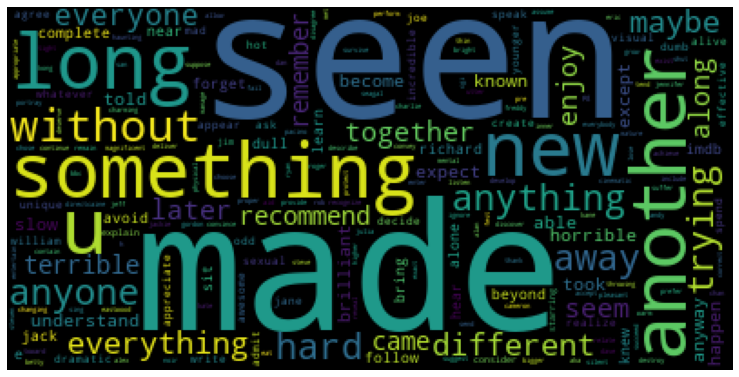

In [324]:
wordcloud.generate(compact_word)
plt.figure(figsize = (13,7))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()